<a href="https://colab.research.google.com/github/Jonathan-Chia/portfolio/blob/main/computer_vision/food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Big

### Check GPU

Need score of 7.0+

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-0d764f2a-1a8a-d086-659e-51365d9a7ba2)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-13 14:51:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-13 14:51:33 (55.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Use TF Datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# will take a while
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # returns (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteY8HTLO/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteY8HTLO/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring Food 101 Data

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# get one sample of train
train_one_sample = train_data.take(4)

In [ ]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape},
  Image Datatype: {image.dtype},
  Target Class: {label},
  Class name: {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3),
  Image Datatype: <dtype: 'uint8'>,
  Target Class: 71,
  Class name: paella
  

  Image Shape: (512, 512, 3),
  Image Datatype: <dtype: 'uint8'>,
  Target Class: 36,
  Class name: falafel
  

  Image Shape: (512, 512, 3),
  Image Datatype: <dtype: 'uint8'>,
  Target Class: 16,
  Class name: cheesecake
  

  Image Shape: (512, 512, 3),
  Image Datatype: <dtype: 'uint8'>,
  Target Class: 93,
  Class name: steak
  


In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

InvalidArgumentError: ignored

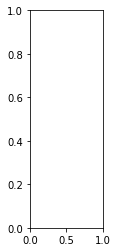

In [ ]:
# num_images = 4
# for i in range(num_images):
#   plt.subplot(1, 4, i+1)
#   plt.title(class_names[label[i].numpy()])
#   plt.imshow(image[i])
#   plt.axis(False);

## Preprocessing functions

Problems with this data
* uint8
* different size images
* not scaled

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

NameError: ignored

## Batch and Prepare Datasets

From tensorflow best practices

In [ ]:
train_data, len(train_data)

(<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 75750)

In [ ]:
tf.data.AUTOTUNE

-1

In [ ]:
# Map preprocessing function to training data + parallelize
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to testing data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE).cache() # prefetch loads the next batch in advance to save time, cache makes it easy to load test_data quick

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <CacheDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks

In [ ]:
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                               save_best_only=True, 
                                                               save_weights_only=True,
                                                               monitor='val_accuracy',
                                                               verbose=0)

#early_stopping_callback = tf.keras.callbacks.EarlyStopping()

In [ ]:
tf.__version__

'2.6.0'

## Mixed Precision

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Build feature extraction model


In [ ]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=93>

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
#x = preprocessing.rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy', # because labels in int form not one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Check if we are using mixed precision

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check dtype of layers in base_model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

In [ ]:
# mixed_precision.set_global_policy('float32')

In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                    batch_size=32,
                                                    epochs=3,
                                                    callbacks=[create_tensorboard_callback("training_logs", 
                                                                                          "efficientnetb0_101_classes_all_data_feature_extract"), 
                                                              model_checkpoint_callback],
                                                    steps_per_epoch=len(train_data), 
                                                    validation_data = test_data,
                                                    validation_steps=int(.15 * len(test_data)))

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210912-031220
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 316s 116ms/step - loss: 1.8208 - accuracy: 0.5585 - val_loss: 1.2297 - val_accuracy: 0.6751


Epoch 2/3
2368/2368 [==============================] - 266s 111ms/step - loss: 1.2925 - accuracy: 0.6672 - val_loss: 1.1345 - val_accuracy: 0.6947


Epoch 3/3
2368/2368 [==============================] - 265s 108ms/step - loss: 1.1423 - accuracy: 0.7029 - val_loss: 1.0964 - val_accuracy: 0.7060


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

Hmm it didn't save my model - maybe because I didn't write out 'val_accuracy'

In [ ]:
# Can I save it now? 
model.save_weights(checkpoint_path)

In [ ]:
# how to move the saved stuff to my drive??

In [ ]:
model.save("drive/My Drive/tensorflow_course/101_food_class_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_saved_big_dog_model/assets


INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_saved_big_dog_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Loading model in

In [ ]:
import tensorflow as tf

saved_model_path = "drive/My Drive/tensorflow_course/101_food_class_saved_big_dog_model"
model = tf.keras.models.load_model(saved_model_path)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
# this is breaking cuz it uses too much ram to evaluate
# results_feature_extract_model = model.evaluate(test_data)
# results_feature_extract_model

435/790 [===============>..............] - ETA: 39s - loss: 1.0853 - accuracy: 0.7067

## preparing layers - unfreezing


In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling2d_2 True
dense_1 True
softmax_float32 True


In [ ]:
# Unfreeze layers in efficient net
for layer in model.layers:
  layer.trainable = True

# # Refreeze every layer except for the last 5
# for layer in model.layers[1].layers[:-5]:
#   layer.trainable = False

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d_2 True
dense_1 True
softmax_float32 True


In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## set up callbacks

In [ ]:
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                               save_best_only=True, 
                                                               save_weights_only=True,
                                                               monitor='val_loss',
                                                               verbose=0)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Compile

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
history_fine_tuned = model.fit(train_data,
          batch_size=32,
          validation_data=test_data,
          validation_steps=int(.15*len(test_data)),
          steps_per_epoch=len(train_data),
          epochs=100,
          callbacks=[create_tensorboard_callback('training_logs','fine_tuned_from_beginning'),
                     model_checkpoint_callback,
                     early_stopping_callback,
                     reduce_lr])

Saving TensorBoard log files to: training_logs/fine_tuned_from_beginning/20210913-151043
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 1218s 490ms/step - loss: 0.9236 - accuracy: 0.7514 - val_loss: 0.8290 - val_accuracy: 0.7691
Epoch 2/100
2368/2368 [==============================] - 1137s 479ms/step - loss: 0.5761 - accuracy: 0.8397 - val_loss: 0.7667 - val_accuracy: 0.7942
Epoch 3/100
2368/2368 [==============================] - 1145s 480ms/step - loss: 0.3310 - accuracy: 0.9067 - val_loss: 0.8595 - val_accuracy: 0.7842
Epoch 4/100
 883/2368 [==========>...................] - ETA: 11:45 - loss: 0.1548 - accuracy: 0.9550

In [ ]:
model.save('drive/My Drive/tensorflow_course/101_food_class_saved_final_big_dog_model')

INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_saved_final_big_dog_model/assets


INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_saved_final_big_dog_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## View on TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Comparing base food 101 vs fine-tuned food 101" \
  --description "blah" \
  --one_shot

2021-09-14 14:58:29.218128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 14:58:29.783502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 14:58:29.784549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

## Plot loss curves

In [ ]:
plot_loss_curves(history_fine_tuned)

## Evaluate model performance

In [ ]:
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

In [ ]:
len(y_labels)

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

In [ ]:

# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot a confusion matrix with all predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Find the most wrong predictions